In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

METADATA = {'Contributor': 'T. Dunn'}
FSIZE = [5,4]
FDPI = 100
SAVEFIGS = False

ALL_SOURCE_BOOKS = ['BR','PH','MM','HotDQ','RoT','DMG','PotA','OotA','SCAG','CoS','SKT','VGtM','TftYP','ToA','XGtE','MToF','WDH','WDotMM','GGtR','GoS','BGDiA','ERftLW','EGtW','MOoT','IDRotF','TCoE','CM','VRGtR','FToD']
ALL_RULES_BOOKS = ['BR','PH','MM','DMG','SCAG','VGtM','XGtE','MToF','GGtR','ERftLW','EGtW','MOoT','TCoE','VRGtR','FToD']
ALL_ADVENTURE_BOOKS = ['HotDQ','RoT','PotA','OotA','CoS','SKT','TftYP','ToA','WDH','WDotMM','GoS','BGDiA','IDRotF','CM']

df0 = pd.read_csv('monster-saves-monk.csv')
len(df0.index.to_list())

1334

In [2]:
# function definitions

def attack_hit_prob(AC, AB):
    return max(0.05, min(0.95, 0.05*(20 + AB - AC)))

def save_hit_prob(SB, DC):
    return max(0.0, min(1.0, 0.05*(DC - SB - 1)))

def effective_DPR(DPR, AB):
    return DPR*np.power(1.05, AB - 6)

def effective_HP(HP, AC):
    return HP*np.power(1.05, AC - 8)

In [3]:
dfMonk = pd.DataFrame({
    'Level':   [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'PB':      [2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6],
    'Dex Mod': [3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5],
    'Wis Mod': [3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5],
})
dfMonk.set_index('Level', inplace=True)
dfMonk['Ki Save DC'] = 8 + dfMonk['Wis Mod'] + dfMonk['PB']
dfMonk['Weapon AB'] = dfMonk['Dex Mod'] + dfMonk['PB']

dfSpell = pd.DataFrame({
    'Level':     [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'PB':        [2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6],
    'Spell Mod': [3,3,3,4,4,4,4,5,5,5,5,5,5,5,5,5,5,5,5,5]
})
dfSpell.set_index('Level', inplace=True)
dfSpell['Spell Save DC'] = 8 + dfSpell['Spell Mod'] + dfSpell['PB']
dfSpell['Spell AB'] = dfSpell['Spell Mod'] + dfSpell['PB']

Level  5, Stun Probability: [0.51 (0.09), 0.43 (0.04), 0.49 (0.10)]
Level 10, Stun Probability: [0.53 (0.13), 0.41 (0.14), 0.52 (0.14)]
Level 15, Stun Probability: [0.48 (0.16), 0.39 (0.16), 0.45 (0.18)]
Level 20, Stun Probability: [0.50 (0.17), 0.43 (0.18), 0.37 (0.22)]


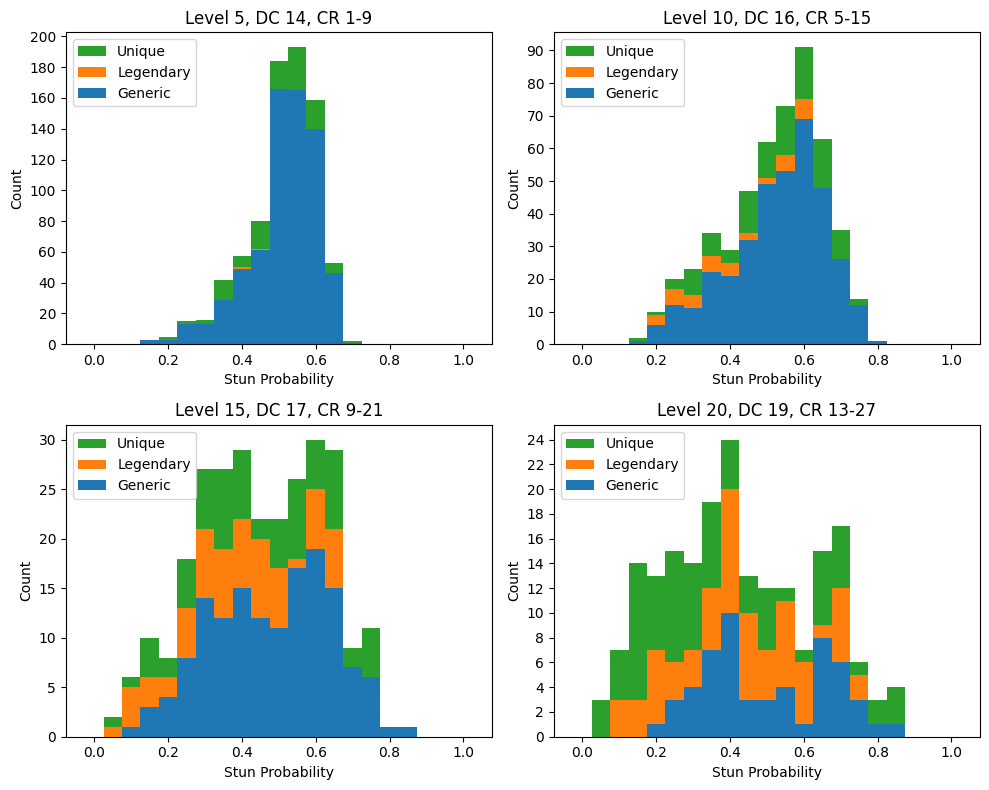

In [4]:
# Stun chance with Stunning Strike

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]
majorLocs = [20, 10,  5,  2]

rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

rSub = 2; cSub = 2; iSub = 0
fig = plt.figure(figsize=[5*cSub,4*rSub], dpi=FDPI, tight_layout=True)
fig.subplots_adjust(hspace=0.3)

for level, CRdelta in zip(levels, CRdeltas):
    iSub = iSub + 1

    CR_min = level - CRdelta
    CR_max = level + CRdelta
    df1 = df0[df0['CR'].between(CR_min, CR_max)]
    df1['Hit Prob'] = df1.apply(lambda row: attack_hit_prob(row['AC'], dfMonk.loc[level, 'Weapon AB']), axis=1)
    df1['Stun Prob'] = df1.apply(lambda row: save_hit_prob(row['Con Save'], dfMonk.loc[level, 'Ki Save DC']), axis=1)

    ax = plt.subplot(rSub, cSub, iSub, xlabel='Stun Probability', ylabel='Count', 
        title="Level {}, DC {}, CR {}-{}".format(level, dfMonk.loc[level, 'Ki Save DC'], CR_min, CR_max))
    ax.hist((df1[df1['Category'].isin(['generic'])]['Stun Prob'], 
             df1[df1['Category'].isin(['legendary'])]['Stun Prob'], 
             df1[df1['Category'].isin(['unique'])]['Stun Prob']),
        rRange, density=False, histtype='stepfilled', stacked=True, label=['Generic','Legendary','Unique'])
    ax.legend(loc='upper left')
    ax.yaxis.set_major_locator(MultipleLocator(majorLocs[iSub-1]))

    dfM = df1.groupby('Category').mean()['Stun Prob']
    dfS = df1.groupby('Category').std()['Stun Prob']
    print('Level {:2d}, Stun Probability: [{:.2f} ({:.2f}), {:.2f} ({:.2f}), {:.2f} ({:.2f})]'.format(level, 
        dfM['generic'], dfS['generic'],
        dfM['legendary'], dfS['legendary'],
        dfM['unique'], dfS['unique']))

if SAVEFIGS: plt.savefig('stun-probability-distribution-categories.svg', metadata=METADATA)

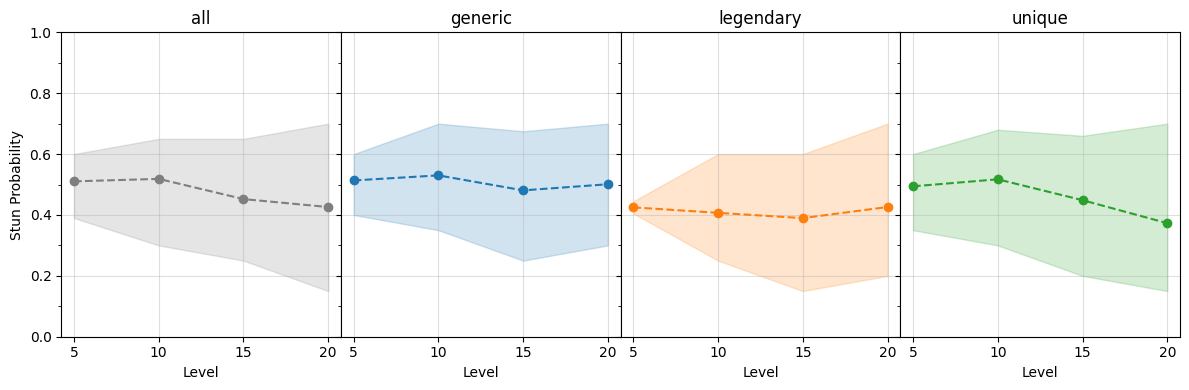

In [5]:
# Probability of landing a Stunning Strike

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]

rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

q1=0.10; q2=0.90
rSub = 1; cSub = 4; iSub = 0
fig = plt.figure(figsize=[3*cSub,4*rSub], dpi=FDPI, tight_layout=True)
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = ['#7f7f7f','#1f77b4','#ff7f0e','#2ca02c']

for cat, ax, c in zip(['all','generic','legendary','unique'], axs, colors):
    yMean = []; yStd  = []; yMin = []; yMax = []
    for level, CRdelta in zip(levels, CRdeltas):
        CR_min = level - CRdelta
        CR_max = level + CRdelta
        df1 = df0[df0['CR'].between(CR_min, CR_max)]
        df1['Hit Prob'] = df1.apply(lambda row: attack_hit_prob(row['AC'], dfMonk.loc[level, 'Weapon AB']), axis=1)
        df1['Stun Prob'] = df1.apply(lambda row: save_hit_prob(row['Con Save'], dfMonk.loc[level, 'Ki Save DC']), axis=1)
        df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']

        if cat == 'all':
            dfC = df1['Stun Prob']
        else:
            dfC = df1[df1['Category'].isin([cat])]['Stun Prob']
        
        yMin.append(dfC.quantile(q1))
        yMax.append(dfC.quantile(q2))
        yMean.append(dfC.mean())

    ax.fill_between(levels, yMin, yMax, alpha=0.2, color=c)
    ax.plot(levels, yMean, 'o--', color=c)
    ax.set_title(cat)

for ax in axs.flat:
    ax.set(xlabel='Level', ylabel='Stun Probability', ylim=[0,1])
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.grid(which='major', axis='both', alpha=0.4)
    ax.label_outer()

if SAVEFIGS: plt.savefig('stun-probability-confidence80-categories.svg', metadata=METADATA)

Level  5, Hit Probability: [0.62 (0.11), 0.60 (0.00), 0.62 (0.13)]
Level 10, Hit Probability: [0.61 (0.10), 0.56 (0.12), 0.63 (0.13)]
Level 15, Hit Probability: [0.64 (0.09), 0.61 (0.11), 0.66 (0.12)]
Level 20, Hit Probability: [0.65 (0.10), 0.63 (0.12), 0.60 (0.12)]


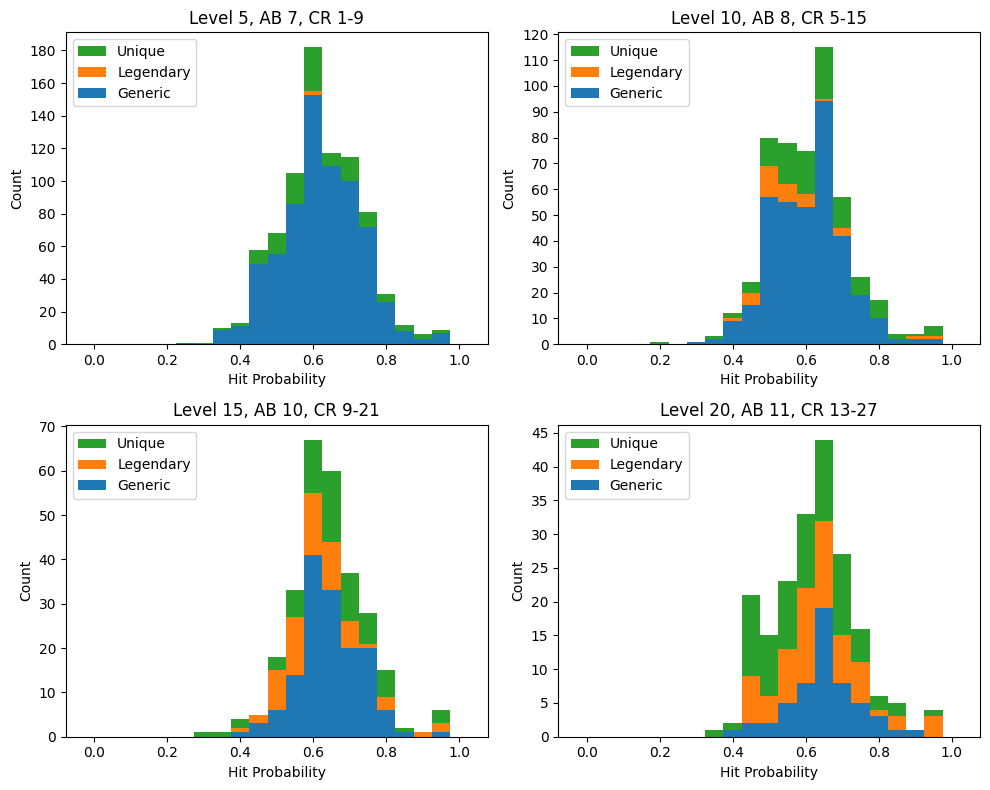

In [6]:
# Attack hit chance

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]
majorLocs = [20, 10, 10,  5]

rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

rSub = 2; cSub = 2; iSub = 0
fig = plt.figure(figsize=[5*cSub,4*rSub], dpi=FDPI, tight_layout=True)
fig.subplots_adjust(hspace=0.3)

for level, CRdelta in zip(levels, CRdeltas):
    iSub = iSub + 1

    CR_min = level - CRdelta
    CR_max = level + CRdelta
    df1 = df0[df0['CR'].between(CR_min, CR_max)]
    df1['Hit Prob'] = df1.apply(lambda row: attack_hit_prob(row['AC'], dfMonk.loc[level, 'Weapon AB']), axis=1)
    df1['Stun Prob'] = df1.apply(lambda row: save_hit_prob(row['Con Save'], dfMonk.loc[level, 'Ki Save DC']), axis=1)

    ax = plt.subplot(rSub, cSub, iSub, xlabel='Hit Probability', ylabel='Count', 
        title="Level {}, AB {}, CR {}-{}".format(level, dfMonk.loc[level, 'Weapon AB'], CR_min, CR_max))
    ax.hist((df1[df1['Category'].isin(['generic'])]['Hit Prob'], 
             df1[df1['Category'].isin(['legendary'])]['Hit Prob'], 
             df1[df1['Category'].isin(['unique'])]['Hit Prob']),
        rRange, density=False, histtype='stepfilled', stacked=True, label=['Generic','Legendary','Unique'])
    ax.legend(loc='upper left')
    ax.yaxis.set_major_locator(MultipleLocator(majorLocs[iSub-1]))

    dfM = df1.groupby('Category').mean()['Hit Prob']
    dfS = df1.groupby('Category').std()['Hit Prob']
    print('Level {:2d}, Hit Probability: [{:.2f} ({:.2f}), {:.2f} ({:.2f}), {:.2f} ({:.2f})]'.format(level, 
        dfM['generic'], dfS['generic'],
        dfM['legendary'], dfS['legendary'],
        dfM['unique'], dfS['unique']))

if SAVEFIGS: plt.savefig('attack-hit-probability-distribution-categories.svg', metadata=METADATA)

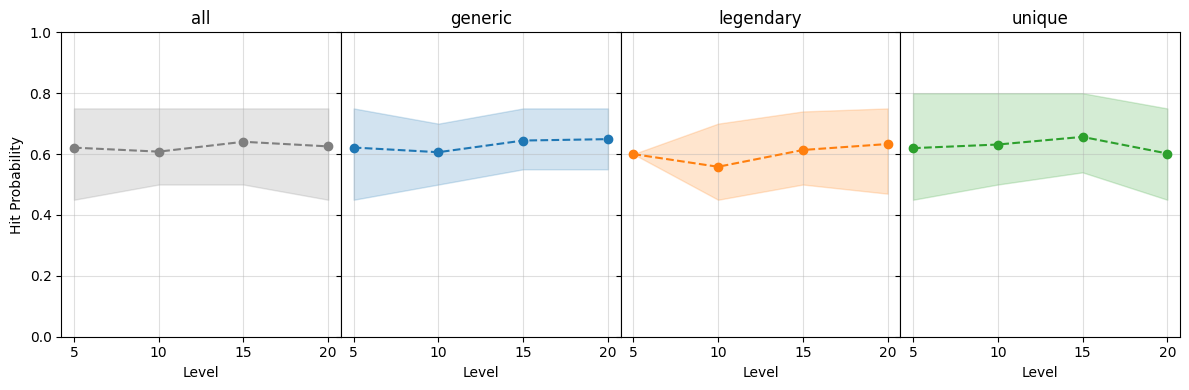

In [7]:
# Attacks hit chance

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]

rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

q1=0.10; q2=0.90
rSub = 1; cSub = 4; iSub = 0
fig = plt.figure(figsize=[3*cSub,4*rSub], dpi=FDPI, tight_layout=True)
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = ['#7f7f7f','#1f77b4','#ff7f0e','#2ca02c']

for cat, ax, c in zip(['all','generic','legendary','unique'], axs, colors):
    yMean = []; yStd  = []; yMin = []; yMax = []
    for level, CRdelta in zip(levels, CRdeltas):
        CR_min = level - CRdelta
        CR_max = level + CRdelta
        df1 = df0[df0['CR'].between(CR_min, CR_max)]
        df1['Hit Prob'] = df1.apply(lambda row: attack_hit_prob(row['AC'], dfMonk.loc[level, 'Weapon AB']), axis=1)
        df1['Stun Prob'] = df1.apply(lambda row: save_hit_prob(row['Con Save'], dfMonk.loc[level, 'Ki Save DC']), axis=1)
        df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']
        df1['Attacks per Stun'] = 1.0/df1['Attack Stun Prob']

        if cat == 'all':
            dfC = df1['Hit Prob']
        else:
            dfC = df1[df1['Category'].isin([cat])]['Hit Prob']
        
        yMin.append(dfC.quantile(q1))
        yMax.append(dfC.quantile(q2))
        yMean.append(dfC.mean())

    ax.fill_between(levels, yMin, yMax, alpha=0.2, color=c)
    ax.plot(levels, yMean, 'o--', color=c)
    ax.set_title(cat)

for ax in axs.flat:
    ax.set(xlabel='Level', ylabel='Hit Probability', ylim=[0,1])
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    #ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.grid(which='major', axis='both', alpha=0.4)
    ax.label_outer()

if SAVEFIGS: plt.savefig('attack-hit-probability-confidence80-categories.svg', metadata=METADATA)

Level  5, Attack Stun Probability: [0.32 (0.09), 0.26 (0.02), 0.31 (0.10)]
Level 10, Attack Stun Probability: [0.33 (0.11), 0.23 (0.09), 0.33 (0.12)]
Level 15, Attack Stun Probability: [0.31 (0.12), 0.24 (0.12), 0.30 (0.14)]
Level 20, Attack Stun Probability: [0.33 (0.12), 0.28 (0.14), 0.23 (0.15)]


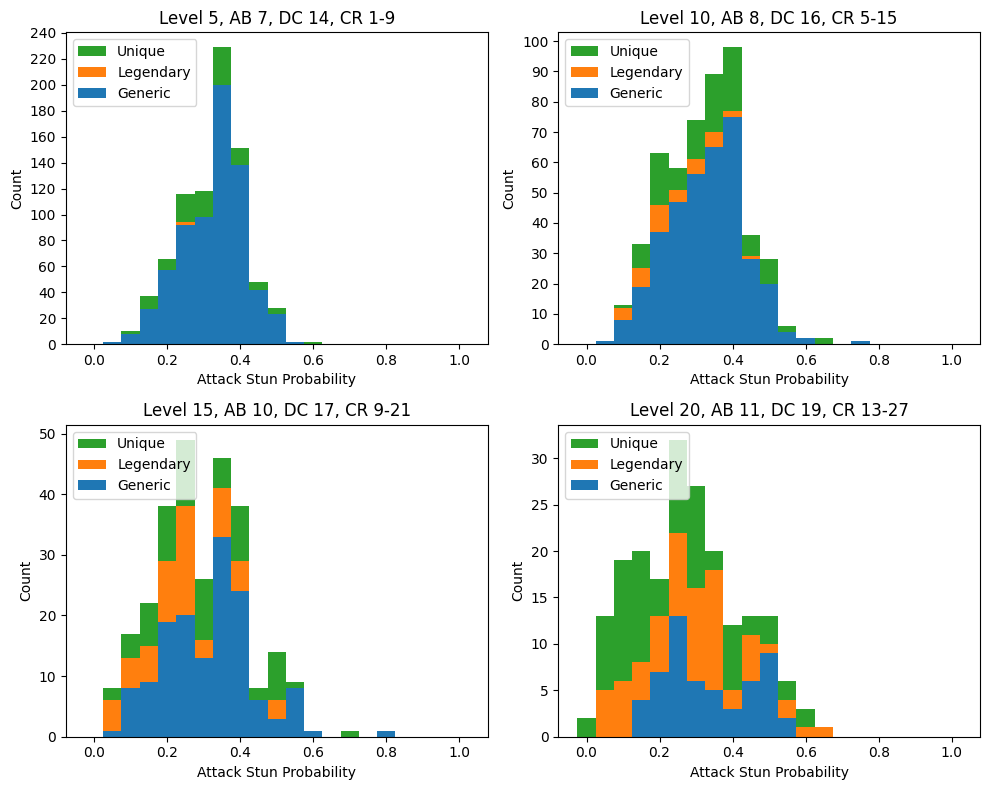

In [8]:
# Attack stun chance

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]
majorLocs = [20, 10, 10,  5]

rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

rSub = 2; cSub = 2; iSub = 0
fig = plt.figure(figsize=[5*cSub,4*rSub], dpi=FDPI, tight_layout=True)
fig.subplots_adjust(hspace=0.3)

for level, CRdelta in zip(levels, CRdeltas):
    iSub = iSub + 1

    CR_min = level - CRdelta
    CR_max = level + CRdelta
    df1 = df0[df0['CR'].between(CR_min, CR_max)]
    df1['Hit Prob'] = df1.apply(lambda row: attack_hit_prob(row['AC'], dfMonk.loc[level, 'Weapon AB']), axis=1)
    df1['Stun Prob'] = df1.apply(lambda row: save_hit_prob(row['Con Save'], dfMonk.loc[level, 'Ki Save DC']), axis=1)
    df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']

    ax = plt.subplot(rSub, cSub, iSub, xlabel='Attack Stun Probability', ylabel='Count', 
        title="Level {}, AB {}, DC {}, CR {}-{}".format(level, dfMonk.loc[level, 'Weapon AB'], 
        dfMonk.loc[level, 'Ki Save DC'], CR_min, CR_max))
        
    ax.hist((df1[df1['Category'].isin(['generic'])]['Attack Stun Prob'], 
             df1[df1['Category'].isin(['legendary'])]['Attack Stun Prob'], 
             df1[df1['Category'].isin(['unique'])]['Attack Stun Prob']),
        rRange, density=False, histtype='stepfilled', stacked=True, label=['Generic','Legendary','Unique'])
    ax.legend(loc='upper left')
    ax.yaxis.set_major_locator(MultipleLocator(majorLocs[iSub-1]))

    dfM = df1.groupby('Category').mean()['Attack Stun Prob']
    dfS = df1.groupby('Category').std()['Attack Stun Prob']
    print('Level {:2d}, Attack Stun Probability: [{:.2f} ({:.2f}), {:.2f} ({:.2f}), {:.2f} ({:.2f})]'.format(level, 
        dfM['generic'], dfS['generic'],
        dfM['legendary'], dfS['legendary'],
        dfM['unique'], dfS['unique']))

if SAVEFIGS: plt.savefig('attack-stun-probability-distribution-categories.svg', metadata=METADATA)

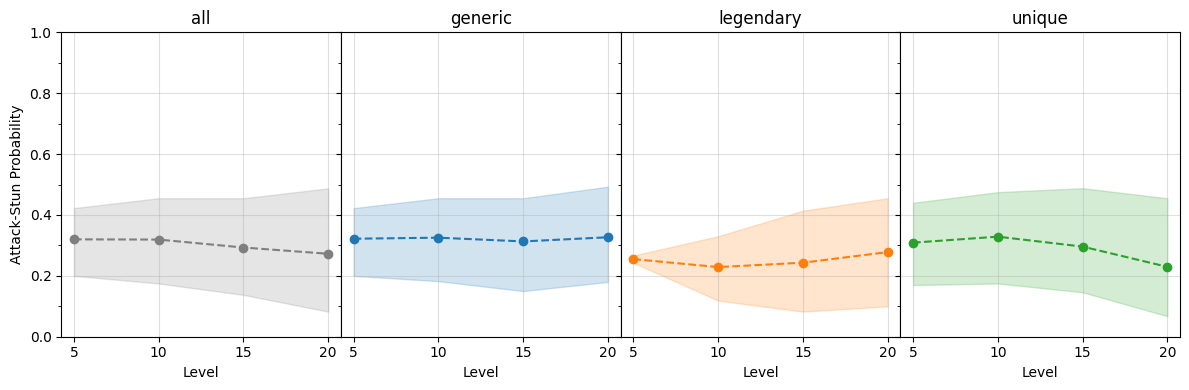

In [9]:
# Probability of hitting with an attack and landing a Stunning Strike

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]

rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

q1=0.10; q2=0.90
rSub = 1; cSub = 4; iSub = 0
fig = plt.figure(figsize=[3*cSub,4*rSub], dpi=FDPI, tight_layout=True)
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = ['#7f7f7f','#1f77b4','#ff7f0e','#2ca02c']

for cat, ax, c in zip(['all','generic','legendary','unique'], axs, colors):
    yMean = []; yStd  = []; yMin = []; yMax = []
    for level, CRdelta in zip(levels, CRdeltas):
        CR_min = level - CRdelta
        CR_max = level + CRdelta
        df1 = df0[df0['CR'].between(CR_min, CR_max)]
        df1['Hit Prob'] = df1.apply(lambda row: attack_hit_prob(row['AC'], dfMonk.loc[level, 'Weapon AB']), axis=1)
        df1['Stun Prob'] = df1.apply(lambda row: save_hit_prob(row['Con Save'], dfMonk.loc[level, 'Ki Save DC']), axis=1)
        df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']

        if cat == 'all':
            dfC = df1['Attack Stun Prob']
        else:
            dfC = df1[df1['Category'].isin([cat])]['Attack Stun Prob']
        
        yMin.append(dfC.quantile(q1))
        yMax.append(dfC.quantile(q2))
        yMean.append(dfC.mean())

    ax.fill_between(levels, yMin, yMax, alpha=0.2, color=c)
    ax.plot(levels, yMean, 'o--', color=c)
    ax.set_title(cat)

for ax in axs.flat:
    ax.set(xlabel='Level', ylabel='Attack-Stun Probability', ylim=[0,1.0])
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.grid(which='major', axis='both', alpha=0.4)
    ax.label_outer()

if SAVEFIGS: plt.savefig('attack-stun-probability-confidence80-categories.svg', metadata=METADATA)

Level  5, Ki per Stun: [1.82 (0.58), 2.36 (0.20), 2.00 (0.63)]
Level 10, Ki per Stun: [1.82 (0.74), 2.50 (1.04), 1.82 (0.83)]
Level 15, Ki per Stun: [2.00 (1.23), 2.50 (3.00), 2.22 (2.63)]
Level 20, Ki per Stun: [2.22 (0.85), 2.50 (2.04), 3.33 (3.89)]


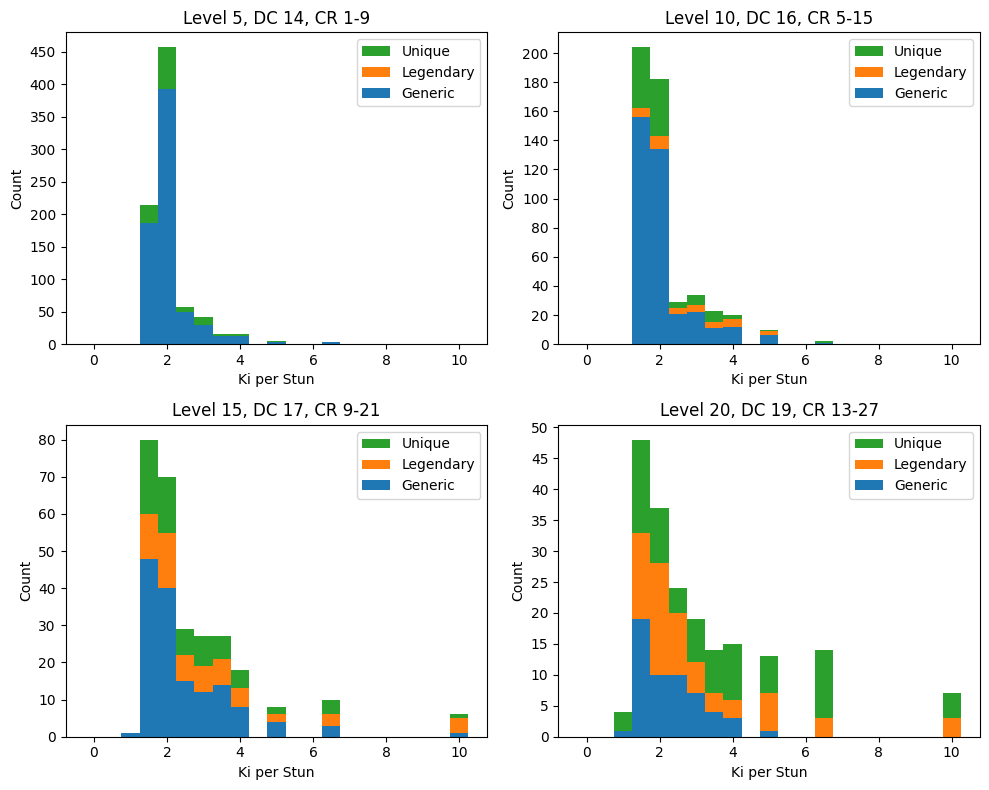

In [10]:
# Ki per Stun chance

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]
majorLocs = [50, 20, 10,  5]

rMin = 0; rMax = 10; rDel = 0.5
rLims = [rMin - rDel/2, rMax + rDel/2]
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

rSub = 2; cSub = 2; iSub = 0
fig = plt.figure(figsize=[5*cSub,4*rSub], dpi=FDPI, tight_layout=True)
fig.subplots_adjust(hspace=0.3)

for level, CRdelta in zip(levels, CRdeltas):
    iSub = iSub + 1

    CR_min = level - CRdelta
    CR_max = level + CRdelta
    df1 = df0[df0['CR'].between(CR_min, CR_max)]
    df1['Hit Prob'] = df1.apply(lambda row: attack_hit_prob(row['AC'], dfMonk.loc[level, 'Weapon AB']), axis=1)
    df1['Stun Prob'] = df1.apply(lambda row: save_hit_prob(row['Con Save'], dfMonk.loc[level, 'Ki Save DC']), axis=1)
    df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']
    df1['Ki per Stun'] = 1.0/df1['Stun Prob']
    df1['Attacks per Stun'] = 1.0/df1['Attack Stun Prob']

    ax = plt.subplot(rSub, cSub, iSub, xlabel='Ki per Stun', ylabel='Count', 
        title="Level {}, DC {}, CR {}-{}".format(level, dfMonk.loc[level, 'Ki Save DC'], CR_min, CR_max))
    ax.hist((df1[df1['Category'].isin(['generic'])]['Ki per Stun'], 
             df1[df1['Category'].isin(['legendary'])]['Ki per Stun'], 
             df1[df1['Category'].isin(['unique'])]['Ki per Stun']),
        rRange, density=False, histtype='stepfilled', stacked=True, label=['Generic','Legendary','Unique'])
    ax.legend(loc='upper right')
    ax.yaxis.set_major_locator(MultipleLocator(majorLocs[iSub-1]))

    dfM = df1.groupby('Category').median()['Ki per Stun']
    dfS = df1.groupby('Category').std()['Ki per Stun']
    print('Level {:2d}, Ki per Stun: [{:.2f} ({:.2f}), {:.2f} ({:.2f}), {:.2f} ({:.2f})]'.format(level, 
        dfM['generic'], dfS['generic'],
        dfM['legendary'], dfS['legendary'],
        dfM['unique'], dfS['unique']))

if SAVEFIGS: plt.savefig('ki-per-stun-probability-distribution-categories.svg', metadata=METADATA)

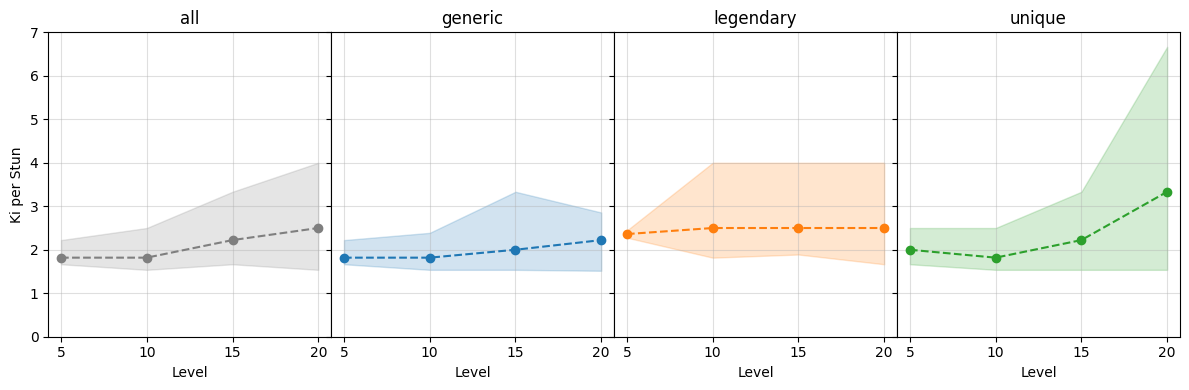

In [11]:
# ki per stun

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]

rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

q1=0.20; q2=0.80
rSub = 1; cSub = 4; iSub = 0
fig = plt.figure(figsize=[3*cSub,4*rSub], dpi=FDPI, tight_layout=True)
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = ['#7f7f7f','#1f77b4','#ff7f0e','#2ca02c']

for cat, ax, c in zip(['all','generic','legendary','unique'], axs, colors):
    yMean = []; yStd  = []; yMin = []; yMax = []
    for level, CRdelta in zip(levels, CRdeltas):
        CR_min = level - CRdelta
        CR_max = level + CRdelta
        df1 = df0[df0['CR'].between(CR_min, CR_max)]
        df1['Hit Prob'] = df1.apply(lambda row: attack_hit_prob(row['AC'], dfMonk.loc[level, 'Weapon AB']), axis=1)
        df1['Stun Prob'] = df1.apply(lambda row: save_hit_prob(row['Con Save'], dfMonk.loc[level, 'Ki Save DC']), axis=1)
        df1['Ki per Stun'] = 1.0/df1['Stun Prob']
        df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']
        df1['Attacks per Stun'] = 1.0/df1['Attack Stun Prob']

        if cat == 'all':
            dfC = df1['Ki per Stun']
        else:
            dfC = df1[df1['Category'].isin([cat])]['Ki per Stun']
        
        yMin.append(dfC.quantile(q1))
        yMax.append(dfC.quantile(q2))
        yMean.append(dfC.median())

    ax.fill_between(levels, yMin, yMax, alpha=0.2, color=c)
    ax.plot(levels, yMean, 'o--', color=c)
    ax.set_title(cat)

for ax in axs.flat:
    ax.set(xlabel='Level', ylabel='Ki per Stun', ylim=[0,7])
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    #ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.grid(which='major', axis='both', alpha=0.4)
    ax.label_outer()

if SAVEFIGS: plt.savefig('ki-per-stun-probability-confidence60-categories.svg', metadata=METADATA)

Level  5, Attacks per Stun: [3.03 (1.62), 3.94 (0.33), 3.31 (1.49)]
Level 10, Attacks per Stun: [3.08 (1.70), 5.19 (2.25), 3.03 (1.59)]
Level 15, Attacks per Stun: [3.08 (2.15), 4.17 (5.44), 3.57 (5.13)]
Level 20, Attacks per Stun: [3.42 (1.45), 3.42 (4.70), 4.58 (8.47)]


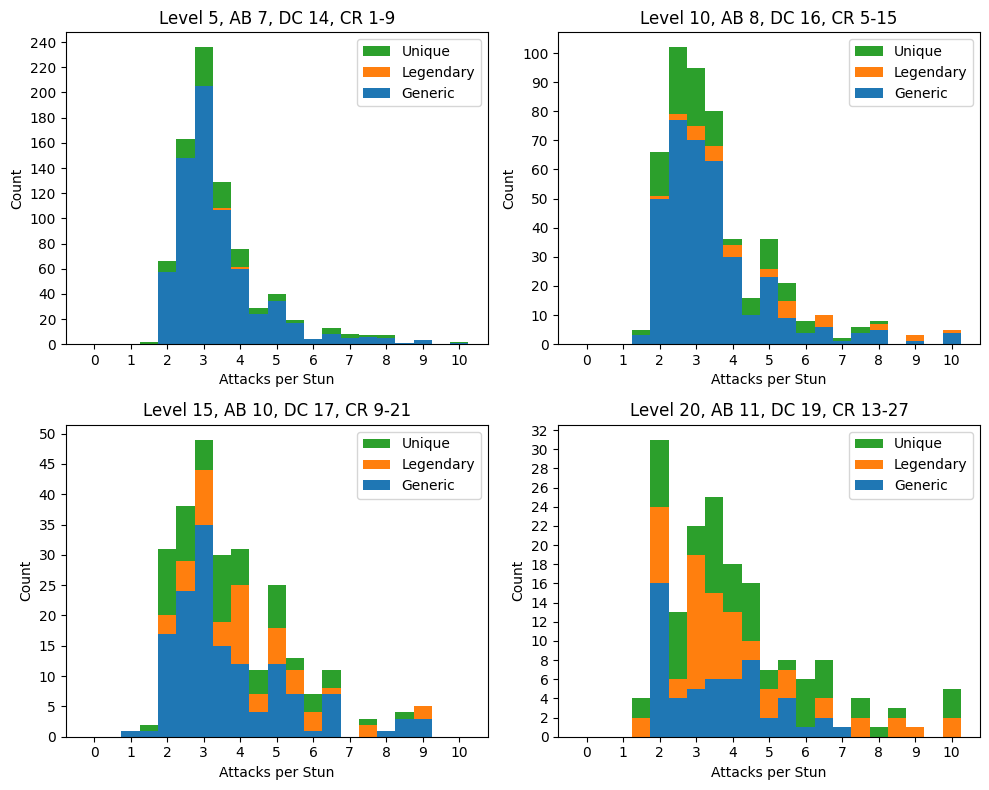

In [12]:
# Attack stun chance

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]
majorLocs = [20, 10,  5,  2]

rMin = 0; rMax = 10; rDel = 0.5
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

rSub = 2; cSub = 2; iSub = 0
fig = plt.figure(figsize=[5*cSub,4*rSub], dpi=FDPI, tight_layout=True)
fig.subplots_adjust(hspace=0.3)

for level, CRdelta in zip(levels, CRdeltas):
    iSub = iSub + 1

    CR_min = level - CRdelta
    CR_max = level + CRdelta
    df1 = df0[df0['CR'].between(CR_min, CR_max)]
    df1['Hit Prob'] = df1.apply(lambda row: attack_hit_prob(row['AC'], dfMonk.loc[level, 'Weapon AB']), axis=1)
    df1['Stun Prob'] = df1.apply(lambda row: save_hit_prob(row['Con Save'], dfMonk.loc[level, 'Ki Save DC']), axis=1)
    df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']
    df1['Ki per Stun'] = 1.0/df1['Stun Prob']
    df1['Attacks per Stun'] = 1.0/df1['Attack Stun Prob']

    ax = plt.subplot(rSub, cSub, iSub, xlabel='Attacks per Stun', ylabel='Count', 
        title="Level {}, AB {}, DC {}, CR {}-{}".format(level, dfMonk.loc[level, 'Weapon AB'], 
        dfMonk.loc[level, 'Ki Save DC'], CR_min, CR_max))
    ax.hist((df1[df1['Category'].isin(['generic'])]['Attacks per Stun'], 
             df1[df1['Category'].isin(['legendary'])]['Attacks per Stun'], 
             df1[df1['Category'].isin(['unique'])]['Attacks per Stun']),
        rRange, density=False, histtype='stepfilled', stacked=True, label=['Generic','Legendary','Unique'])
    ax.legend(loc='upper right')
    ax.yaxis.set_major_locator(MultipleLocator(majorLocs[iSub-1]))
    ax.xaxis.set_major_locator(MultipleLocator(1))

    dfM = df1.groupby('Category').median()['Attacks per Stun']
    dfS = df1.groupby('Category').std()['Attacks per Stun']
    print('Level {:2d}, Attacks per Stun: [{:.2f} ({:.2f}), {:.2f} ({:.2f}), {:.2f} ({:.2f})]'.format(level, 
        dfM['generic'], dfS['generic'],
        dfM['legendary'], dfS['legendary'],
        dfM['unique'], dfS['unique']))

if SAVEFIGS: plt.savefig('attacks-per-stun-probability-distribution-categories.svg', metadata=METADATA)

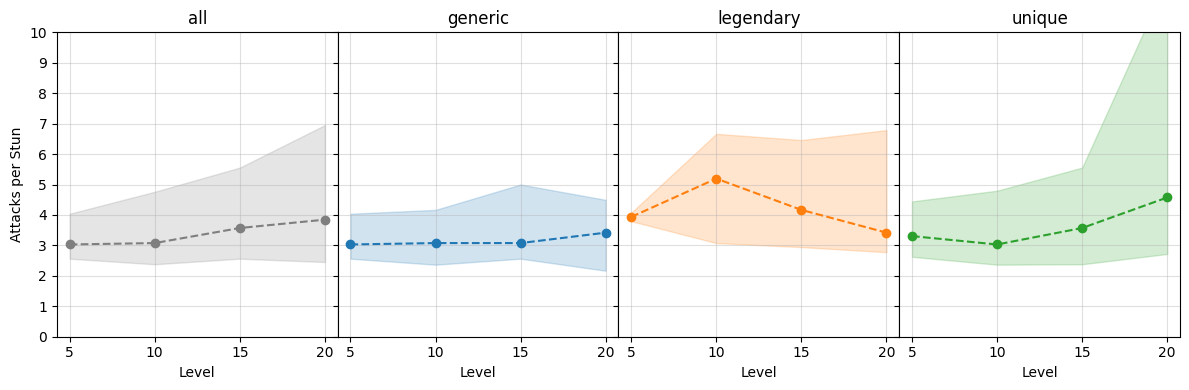

In [13]:
# Attacks per stun

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]

rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

q1=0.20; q2=0.80
rSub = 1; cSub = 4; iSub = 0
fig = plt.figure(figsize=[3*cSub,4*rSub], dpi=FDPI, tight_layout=True)
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = ['#7f7f7f','#1f77b4','#ff7f0e','#2ca02c']

for cat, ax, c in zip(['all','generic','legendary','unique'], axs, colors):
    yMean = []; yStd  = []; yMin = []; yMax = []
    for level, CRdelta in zip(levels, CRdeltas):
        CR_min = level - CRdelta
        CR_max = level + CRdelta
        df1 = df0[df0['CR'].between(CR_min, CR_max)]
        df1['Hit Prob'] = df1.apply(lambda row: attack_hit_prob(row['AC'], dfMonk.loc[level, 'Weapon AB']), axis=1)
        df1['Stun Prob'] = df1.apply(lambda row: save_hit_prob(row['Con Save'], dfMonk.loc[level, 'Ki Save DC']), axis=1)
        df1['Ki per Stun'] = 1.0/df1['Stun Prob']
        df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']
        df1['Attacks per Stun'] = 1.0/df1['Attack Stun Prob']

        if cat == 'all':
            dfC = df1['Attacks per Stun']
        else:
            dfC = df1[df1['Category'].isin([cat])]['Attacks per Stun']
        
        yMin.append(dfC.quantile(q1))
        yMax.append(dfC.quantile(q2))
        yMean.append(dfC.median())

    ax.fill_between(levels, yMin, yMax, alpha=0.2, color=c)
    ax.plot(levels, yMean, 'o--', color=c)
    ax.set_title(cat)

for ax in axs.flat:
    ax.set(xlabel='Level', ylabel='Attacks per Stun', ylim=[0,10])
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    #ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.grid(which='major', axis='both', alpha=0.4)
    ax.label_outer()

if SAVEFIGS: plt.savefig('attacks-per-stun-confidence60-categories.svg', metadata=METADATA)

Level  5, Stun Probability: [0.36 (0.08), 0.54 (0.07)]
Level 10, Stun Probability: [0.37 (0.09), 0.60 (0.08)]
Level 15, Stun Probability: [0.33 (0.11), 0.60 (0.09)]
Level 20, Stun Probability: [0.32 (0.13), 0.65 (0.11)]


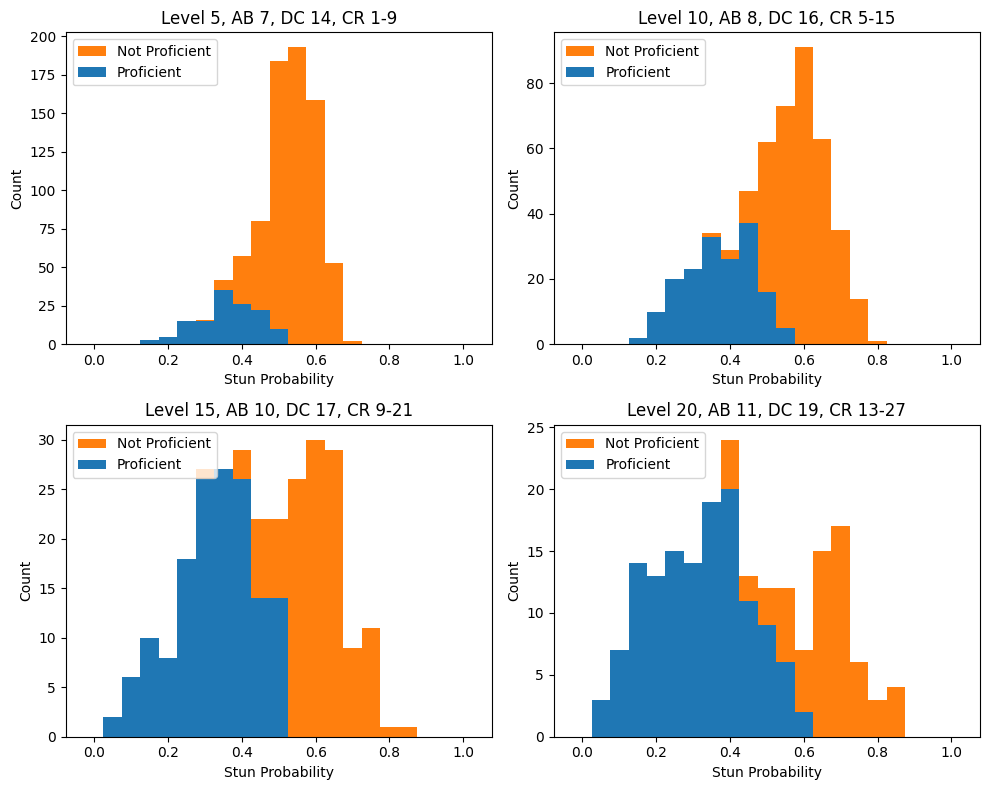

In [14]:
# stun probability grouped

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]
majorLocs = [20, 10, 10,  5]

rMin = 0; rMax = 1; rDel = 0.05
rLims = [rMin - rDel/2, rMax + rDel/2]
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

rSub = 2; cSub = 2; iSub = 0
fig = plt.figure(figsize=[5*cSub,4*rSub], dpi=FDPI, tight_layout=True)
fig.subplots_adjust(hspace=0.3)

for level, CRdelta in zip(levels, CRdeltas):
    iSub = iSub + 1

    CR_min = level - CRdelta
    CR_max = level + CRdelta
    df1 = df0[df0['CR'].between(CR_min, CR_max)]
    df1['Hit Prob'] = df1.apply(lambda row: attack_hit_prob(row['AC'], dfMonk.loc[level, 'Weapon AB']), axis=1)
    df1['Stun Prob'] = df1.apply(lambda row: save_hit_prob(row['Con Save'], dfMonk.loc[level, 'Ki Save DC']), axis=1)
    df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']

    ax = plt.subplot(rSub, cSub, iSub, xlabel='Stun Probability', ylabel='Count', 
        title="Level {}, AB {}, DC {}, CR {}-{}".format(level, dfMonk.loc[level, 'Weapon AB'], 
        dfMonk.loc[level, 'Ki Save DC'], CR_min, CR_max))
    ax.hist((df1[df1['Con Prof'].isin([True])]['Stun Prob'], 
             df1[df1['Con Prof'].isin([False])]['Stun Prob']),
        rRange, density=False, histtype='stepfilled', stacked=True, label=['Proficient','Not Proficient'])
    ax.legend(loc='upper left')
    #ax.yaxis.set_major_locator(MultipleLocator(majorLocs[iSub-1]))

    dfP = df1[df1['Con Prof'].isin([True])]['Stun Prob']
    dfN = df1[df1['Con Prof'].isin([False])]['Stun Prob']
    print('Level {:2d}, Stun Probability: [{:.2f} ({:.2f}), {:.2f} ({:.2f})]'.format(level, 
        dfP.mean(), dfP.std(),
        dfN.mean(), dfN.std()))

if SAVEFIGS: plt.savefig('stun-probability-distribution-proficient.svg', metadata=METADATA)

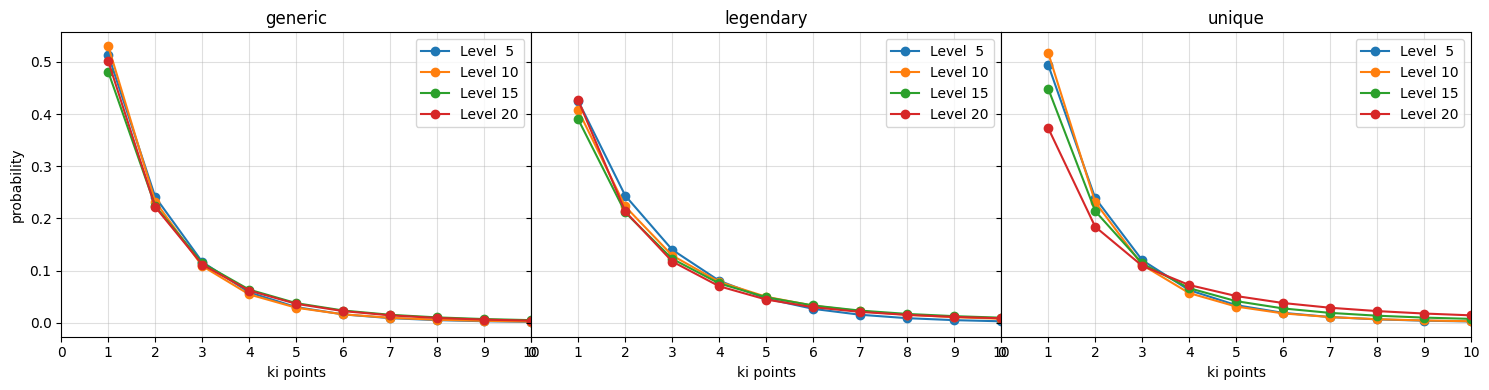

In [15]:
# Attack-Stun probability range

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]
majorLocs = [20, 10,  2,  2]

attempts = range(1,30)

rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

rSub = 1; cSub = 3; iSub = 0
fig = plt.figure(figsize=[5*cSub,4*rSub], dpi=FDPI, tight_layout=True)
gs = fig.add_gridspec(rSub, cSub, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for cat, ax in zip(['generic','legendary','unique'], axs):
    ax.set(title=cat, ylabel='probability', xlabel='ki points')
    kMean = []
    for level, CRdelta in zip(levels, CRdeltas):
        CR_min = level - CRdelta
        CR_max = level + CRdelta
        df1 = df0[df0['CR'].between(CR_min, CR_max)]
        df1['Hit Prob'] = df1.apply(lambda row: attack_hit_prob(row['AC'], dfMonk.loc[level, 'Weapon AB']), axis=1)
        df1['Stun Prob'] = df1.apply(lambda row: save_hit_prob(row['Con Save'], dfMonk.loc[level, 'Ki Save DC']), axis=1)
        df1['Ki per Stun'] = 1.0/df1['Stun Prob']
        df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']
        df1['Attacks per Stun'] = 1.0/df1['Attack Stun Prob']

        dfC = df1[df1['Category'].isin([cat])]
        yMean = []
        for att in attempts:
            yMean.append(np.mean(dfC['Stun Prob']*np.power(1 - dfC['Stun Prob'], att-1)))

        ax.plot(attempts, yMean, 'o-', label='Level {:2d}'.format(level))
        kMean.append(np.dot(yMean, attempts))

    #print('{} - Level {:2d}: ['.format(cat, level), ', '.join('{:.2f}'.format(k) for k in kMean), '] ki per stun')

for ax in axs.flat:
    ax.legend()
    ax.set(xlim=[0,10])
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.grid(which='major', axis='both', alpha=0.4)
    ax.label_outer()

#if SAVEFIGS: plt.savefig('stun-per-ki-probability-distribution.svg', metadata=METADATA)

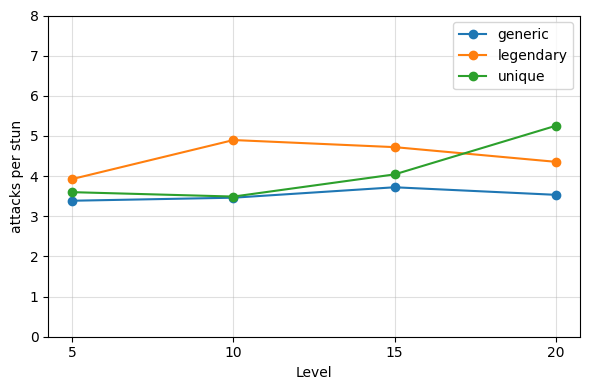

In [16]:
# Attack-Stun probability range

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]
majorLocs = [20, 10,  2,  2]

attempts = range(1,30)

col = 'Attack Stun Prob'
rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig = plt.figure(dpi=FDPI, tight_layout=True)
ax = plt.axes(xlabel='Level', ylabel='attacks per stun', ylim=[0,8])

for cat in ['generic','legendary','unique']:
    kMean = []
    for level, CRdelta in zip(levels, CRdeltas):
        CR_min = level - CRdelta
        CR_max = level + CRdelta
        df1 = df0[df0['CR'].between(CR_min, CR_max)]
        df1['Hit Prob'] = df1.apply(lambda row: attack_hit_prob(row['AC'], dfMonk.loc[level, 'Weapon AB']), axis=1)
        df1['Stun Prob'] = df1.apply(lambda row: save_hit_prob(row['Con Save'], dfMonk.loc[level, 'Ki Save DC']), axis=1)
        df1['Ki per Stun'] = 1.0/df1['Stun Prob']
        df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']
        df1['Attacks per Stun'] = 1.0/df1['Attack Stun Prob']

        dfC = df1[df1['Category'].isin([cat])]
        yMean = []
        for att in attempts:
            yMean.append(np.mean(dfC[col]*np.power(1 - dfC[col], att-1)))

        kMean.append(np.dot(yMean, attempts))

    ax.plot(levels, kMean, 'o-', label=cat)

ax.legend()
ax.grid(which='major', axis='both', alpha=0.4)
ax.xaxis.set_major_locator(MultipleLocator(5))

#if SAVEFIGS: plt.savefig('attacks-per-stun-mean.svg', metadata=METADATA)

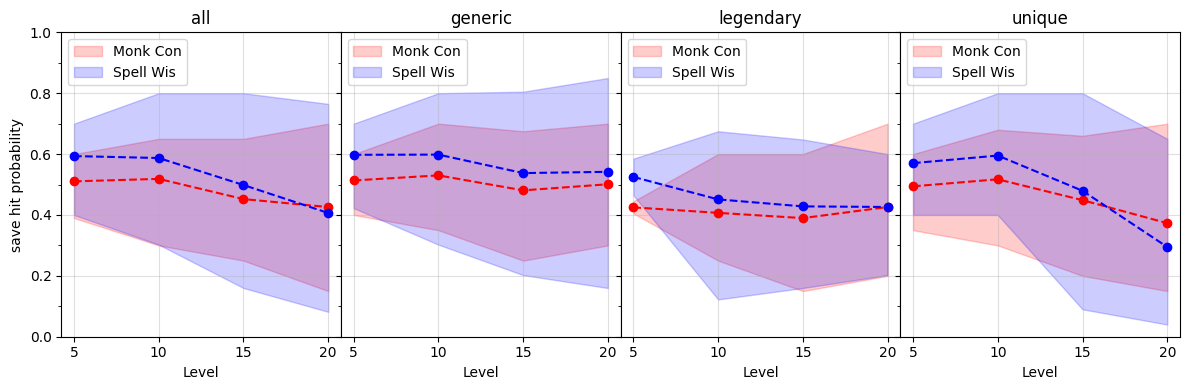

In [17]:
# Probability of landing a Stunning Strike vs landing a spell with a Wisdom saving throw

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]

rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

q1=0.10; q2=0.90
rSub = 1; cSub = 4; iSub = 0
fig = plt.figure(figsize=[3*cSub,4*rSub], dpi=FDPI, tight_layout=True)
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = ['#7f7f7f','#1f77b4','#ff7f0e','#2ca02c']

for cat, ax, c in zip(['all','generic','legendary','unique'], axs, colors):
    yMean = []; yStd  = []; yMin = []; yMax = []
    for level, CRdelta in zip(levels, CRdeltas):
        CR_min = level - CRdelta
        CR_max = level + CRdelta
        df1 = df0[df0['CR'].between(CR_min, CR_max)]
        df1['Stun Prob'] = df1.apply(lambda row: save_hit_prob(row['Con Save'], dfMonk.loc[level, 'Ki Save DC']), axis=1)

        if cat == 'all':
            dfC = df1['Stun Prob']
        else:
            dfC = df1[df1['Category'].isin([cat])]['Stun Prob']
        
        yMin.append(dfC.quantile(q1))
        yMax.append(dfC.quantile(q2))
        yMean.append(dfC.mean())

    ax.fill_between(levels, yMin, yMax, alpha=0.2, color='r', label='Monk Con')
    ax.plot(levels, yMean, 'o--', color='r')

    yMean = []; yStd  = []; yMin = []; yMax = []
    for level, CRdelta in zip(levels, CRdeltas):
        CR_min = level - CRdelta
        CR_max = level + CRdelta
        df1 = df0[df0['CR'].between(CR_min, CR_max)]
        df1['Spell Prob'] = df1.apply(lambda row: np.power(save_hit_prob(row['Wis Save'], dfSpell.loc[level, 'Spell Save DC']), 1 + row['Magic Resistance']), axis=1)

        if cat == 'all':
            dfC = df1['Spell Prob']
        else:
            dfC = df1[df1['Category'].isin([cat])]['Spell Prob']
        
        yMin.append(dfC.quantile(q1))
        yMax.append(dfC.quantile(q2))
        yMean.append(dfC.mean())
    
    ax.fill_between(levels, yMin, yMax, alpha=0.2, color='b', label='Spell Wis')
    ax.plot(levels, yMean, 'o--', color='b')
    ax.set_title(cat)
    ax.legend(loc='upper left')

for ax in axs.flat:
    ax.set(xlabel='Level', ylabel='save hit probability', ylim=[0,1])
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.grid(which='major', axis='both', alpha=0.4)
    ax.label_outer()

if SAVEFIGS: plt.savefig('stun-spell-probability-confidence80-categories.svg', metadata=METADATA)

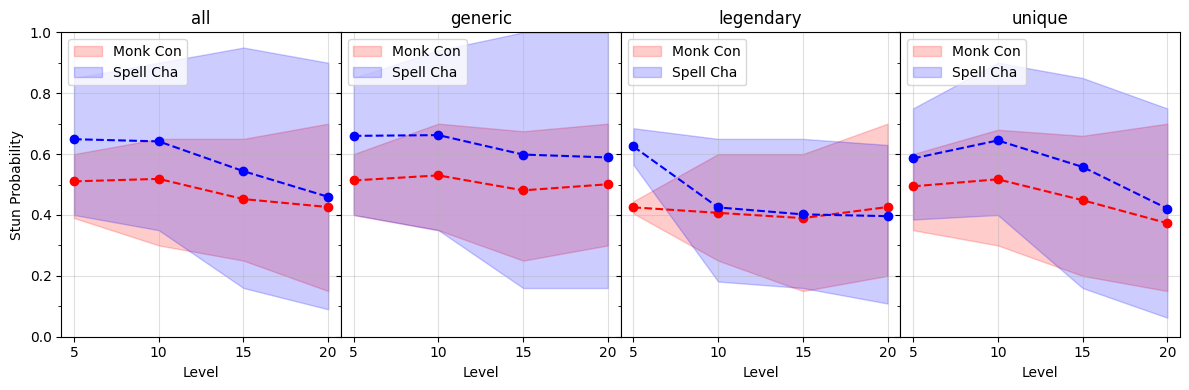

In [18]:
# Probability of landing a Stunning Strike vs landing a spell with a Charisma saving throw

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]

rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

q1=0.10; q2=0.90
rSub = 1; cSub = 4; iSub = 0
fig = plt.figure(figsize=[3*cSub,4*rSub], dpi=FDPI, tight_layout=True)
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = ['#7f7f7f','#1f77b4','#ff7f0e','#2ca02c']

for cat, ax, c in zip(['all','generic','legendary','unique'], axs, colors):
    yMean = []; yStd  = []; yMin = []; yMax = []
    for level, CRdelta in zip(levels, CRdeltas):
        CR_min = level - CRdelta
        CR_max = level + CRdelta
        df1 = df0[df0['CR'].between(CR_min, CR_max)]
        df1['Stun Prob'] = df1.apply(lambda row: save_hit_prob(row['Con Save'], dfMonk.loc[level, 'Ki Save DC']), axis=1)

        if cat == 'all':
            dfC = df1['Stun Prob']
        else:
            dfC = df1[df1['Category'].isin([cat])]['Stun Prob']
        
        yMin.append(dfC.quantile(q1))
        yMax.append(dfC.quantile(q2))
        yMean.append(dfC.mean())

    ax.fill_between(levels, yMin, yMax, alpha=0.2, color='r', label='Monk Con')
    ax.plot(levels, yMean, 'o--', color='r')

    yMean = []; yStd  = []; yMin = []; yMax = []
    for level, CRdelta in zip(levels, CRdeltas):
        CR_min = level - CRdelta
        CR_max = level + CRdelta
        df1 = df0[df0['CR'].between(CR_min, CR_max)]
        df1['Spell Prob'] = df1.apply(lambda row: np.power(save_hit_prob(row['Cha Save'], dfSpell.loc[level, 'Spell Save DC']), 1 + row['Magic Resistance']), axis=1)

        if cat == 'all':
            dfC = df1['Spell Prob']
        else:
            dfC = df1[df1['Category'].isin([cat])]['Spell Prob']
        
        yMin.append(dfC.quantile(q1))
        yMax.append(dfC.quantile(q2))
        yMean.append(dfC.mean())
    
    ax.fill_between(levels, yMin, yMax, alpha=0.2, color='b', label='Spell Cha')
    ax.plot(levels, yMean, 'o--', color='b')
    ax.set_title(cat)
    ax.legend(loc='upper left')

for ax in axs.flat:
    ax.set(xlabel='Level', ylabel='Stun Probability', ylim=[0,1])
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.grid(which='major', axis='both', alpha=0.4)
    ax.label_outer()

#if SAVEFIGS: plt.savefig('stun-spell-charisma-probability-confidence80-categories.svg', metadata=METADATA)